<a href="https://colab.research.google.com/github/arieles08/TP1_DMCyT/blob/main/TP1_v2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##      **TP1**
#                2do cuatrimestre 2022 

**Clustering de Imágenes**

### Librerias y Paquetes

In [ ]:
# for loading/processing the images:

#from keras.preprocessing.image import load_img 
#from keras.preprocessing.image import img_to_array 
from keras.applications.vgg16 import preprocess_input 
from tensorflow.keras.utils  import load_img
from tensorflow.keras.utils import img_to_array


# models 
from keras.applications.vgg16 import VGG16 
from keras.models import Model

# clustering and dimension reduction
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

# for everything else
import os
import numpy as np
import matplotlib.pyplot as plt
from random import randint
import pandas as pd
import random
#import pickle



### Definición de Funciones

In [ ]:
model = VGG16()
model = Model(inputs = model.inputs, outputs = model.layers[-2].output)

553467096/553467096 [==============================] - 5s 0us/step


In [ ]:
def preprocess(lista, model):
    
    datays = {}
    for i in lista:
      featuress = extract_features(i, model)
      datays[i] = featuress               
    # lista de filenames
    filenmss = np.array(list(datays.keys()))
    
    # lista de features
    featsss = np.array(list(datays.values()))

    # reshape 4096 features por el número de imagens 
    featsss = featsss.reshape(-1,4096)
    return filenmss, featsss

In [ ]:
def extract_features(file, model):
    # levanta imagen como array 224x224 
    img = load_img(file, target_size=(224,224))
    # convierte img a numpy array (originalmente es 'PIL.Image.Image') 
    img = np.array(img) 
    # reshape para tener formato necesario para el modelo (num_of_samples, dim 1, dim 2, channels)
    reshaped_img = img.reshape(1,224,224,3) 
    # prepara imagen para modelo (función de keras)
    imgx = preprocess_input(reshaped_img)
    # extrae features
    features = model.predict(imgx, use_multiprocessing=True)
    return features

In [ ]:
# function that lets you view a cluster (based on identifier)        
def view_cluster(gps,cluster):
    plt.figure(figsize = (25,25));
    # gets the list of filenames for a cluster
    files = gps
    # only allow up to 30 images to be shown at a time
    if len(files) > 10:
        print(f"Clipping cluster size from {len(files)} to 10")
        files = files[:9]
    # plot each image in the cluster
    for index, file in enumerate(files):
        plt.subplot(1,10,index+1);
        img = load_img(file)
        img = np.array(img)
        plt.imshow(img)
        plt.title('Cluster n:' + str(cluster))
        plt.axis('off')

# 0.**Preparación de los datos**

### a) Levantar las imágenes y sus etiquetas.

In [ ]:
#Acceso a Google Drive:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
# PASO 1.1: Crear variable "image_path" con la ruta de la carpeta "natural_images" --> Nota: CAMBIAR RUTA DE ARCHIVOS A LA DE CADA UNO
image_path = "/content/drive/MyDrive/Colab Notebooks/natural_images"

# ???
from pathlib import Path
path = [ archivo.as_posix() for archivo in Path('/content/drive/MyDrive/Colab Notebooks/natural_images').glob('*/*')]                        

### (b) Documentar las propiedades del dataset a utilizar.

### (c) Describir sus atributos, de forma semejante a lo realizado en el pre-informe.

## (d) Recuerde que las imágenes deben ser comparables en color, valor, rango y tamaño.

# 1. **Extracción de features**
Se propone el uso de **un modelo de redes neuronales convolucionales VGG16**, es un **modelo de Transfer Learning que posee 16 capas (con pesos) pre entrenado** para clasificación de imágenes. 

Dicho modelo está **implementado en Keras** https://keras.io/api/applications/vgg/ y por default **trabaja con imágenes de 224x224**.
Este modelo es **entrenado de forma supervisada** para clasificación y **aprende en las capas intermedias** características que son relevante para dicha tarea. En el presente trabajo les proponemos utilizar estas características utilizando la salida de las capas intermdias.

Siguiendo los pasos descriptos en las clases, **explorar el output del modelo y documentar el proceso y las características del mismo**.

In [ ]:
#Modelo de redes neuronales:



# 2. **Clustering**

## 2.1 KMeans

#### (a) **Aplicar KMeans** sobre el conjuntos de datos 
> con **distintas métricas, normalizaciones, combinaciones**, etc
 
> Determinar la **cantidad de clusters** utilizando **silhuette y SSE.**


Selecciono al azar 1000 imagenes 

In [ ]:
random.seed(10)
path = random.sample(path, 1000)

In [ ]:
# Levanta archivos y extrae features
names, feat = preprocess(path, model)

1/1 [==============================] - 1s 544ms/step


In [ ]:
# reduce the amount of dimensions in the feature vector
pca = PCA(n_components=100, random_state=22)
pca.fit(feat)
x = pca.transform(feat)


In [ ]:
print(f"Components before PCA: {feat.shape[1]}")
print(f"Components after PCA: {pca.n_components}")


Components before PCA: 4096
Components after PCA: 100


### 2.1.1 KMeans con parametros por default

* init: k-means++
* n_initint =10
* max_iterint= 300
* tolfloat=1e-4
* algorithm=”lloyd”

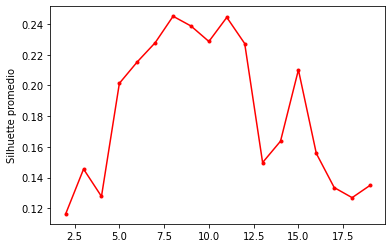

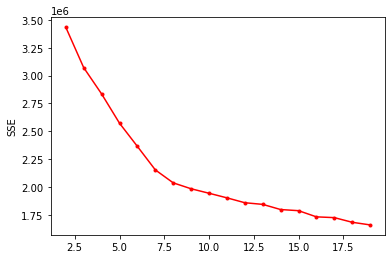

In [ ]:
from sklearn.metrics import silhouette_samples, silhouette_score
range_k = [i for i in range(2,20)]
silh = []
sse = []
for k in range_k:
#    KM_meta = KMedoids(n_clusters=k,metric='precomputed',init='k-medoids++').fit(d_meta)
    Kmeans = KMeans(n_clusters=k).fit(x)

    silh.append(silhouette_score(x,Kmeans.labels_))
    sse.append(Kmeans.inertia_)

plt.plot(range_k,silh,'r.-')
plt.ylabel('Silhuette promedio')
plt.show()

plt.plot(range_k,sse,'r.-')
plt.ylabel('SSE')
plt.show()

In [ ]:
#kmeans = KMeans(n_clusters=len(unique_labels))
kmeans = KMeans(n_clusters=8, random_state=22)
kmeans.fit(x)

KMeans(random_state=22)

In [ ]:
# holds the cluster id and the images { id: [images] }
groups = {}
for file, cluster in zip(names,kmeans.labels_):
    if cluster not in groups.keys():
        groups[cluster] = []
        groups[cluster].append(file)
    else:
        groups[cluster].append(file)
    

Clipping cluster size from 113 to 10
Clipping cluster size from 76 to 10
Clipping cluster size from 121 to 10
Clipping cluster size from 118 to 10
Clipping cluster size from 116 to 10
Clipping cluster size from 140 to 10
Clipping cluster size from 147 to 10
Clipping cluster size from 169 to 10


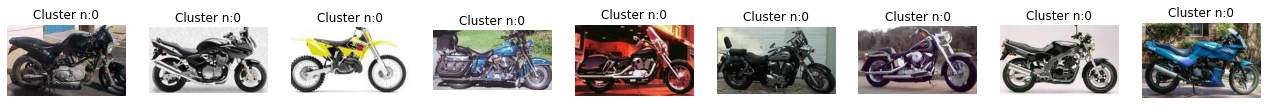

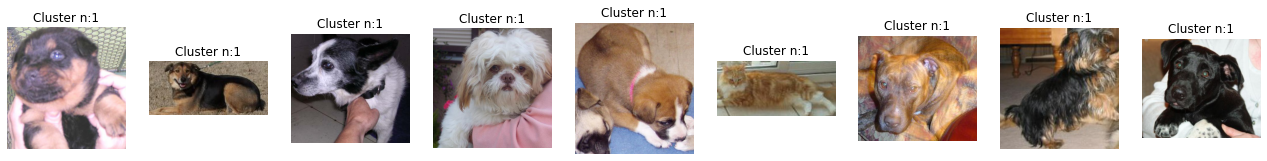

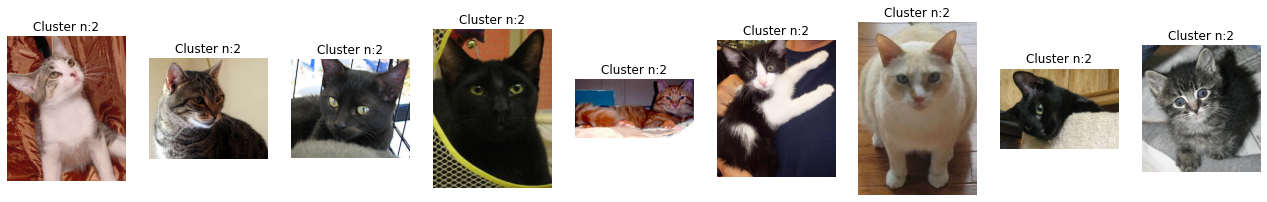

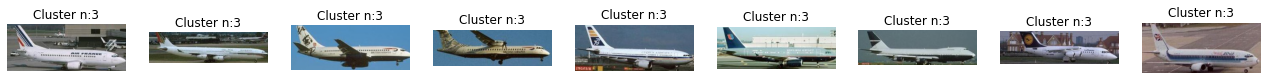

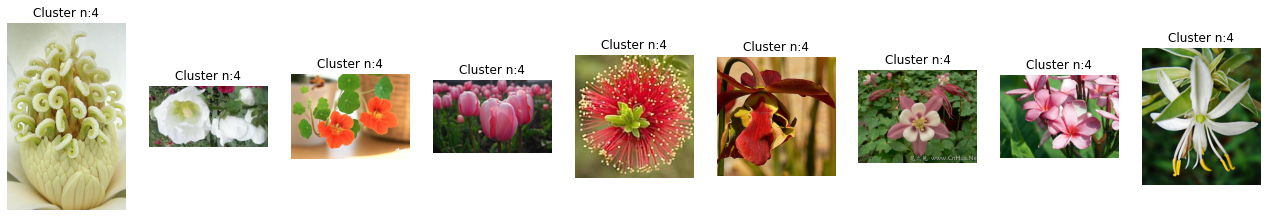

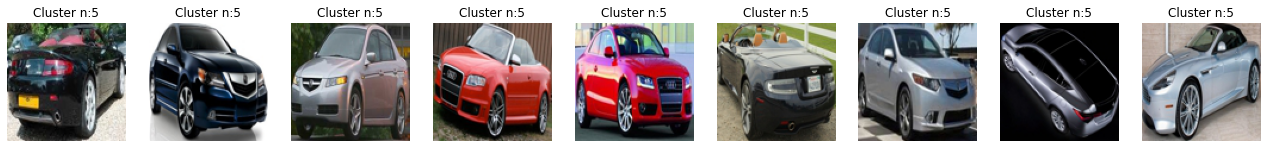

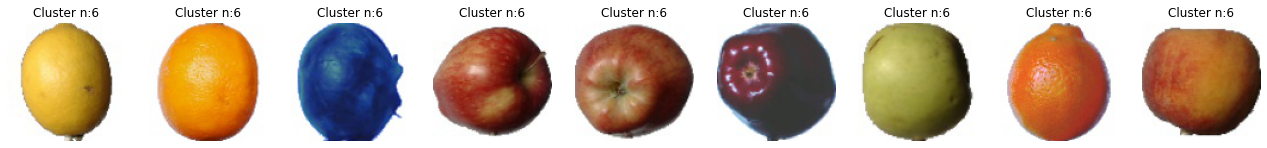

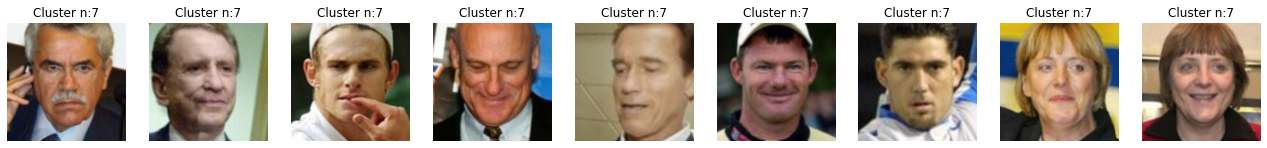

In [ ]:
for n in range(len(groups)):
  view_cluster(groups[n],n)

#### (b) **Evaluar si el agrupamiento para el k óptimo se condice que las etiquetas de las imágenes**  utilizando:

> la **matriz de confusión** y  

> los **índices de Rand y van Dongen** en los casos que correspondan.



In [ ]:
from tensorflow.python.eager.context import DEVICE_PLACEMENT_SILENT_FOR_INT32
df_0=pd.DataFrame(groups[0],columns=["path"])
df_0['Labels'] = pd.Series(['dog' for x in range(len(df_0.index))])
df_1=pd.DataFrame(groups[1],columns=["path"])
df_1['Labels'] = pd.Series(['cat' for x in range(len(df_1.index))])
df_2=pd.DataFrame(groups[2],columns=["path"])
df_2['Labels'] = pd.Series(['person' for x in range(len(df_2.index))])
df_3=pd.DataFrame(groups[3],columns=["path"])
df_3['Labels'] = pd.Series(['motorbike' for x in range(len(df_3.index))])
df_4=pd.DataFrame(groups[4],columns=["path"])
df_4['Labels'] = pd.Series(['fruit' for x in range(len(df_4.index))])
df_5=pd.DataFrame(groups[5],columns=["path"])
df_5['Labels'] = pd.Series(['car' for x in range(len(df_5.index))])
df_6=pd.DataFrame(groups[6],columns=["path"])
df_6['Labels'] = pd.Series(['airplane' for x in range(len(df_6.index))])
df_7=pd.DataFrame(groups[7],columns=["path"])
df_7['Labels'] = pd.Series(['flower' for x in range(len(df_7.index))])
df_kmean=pd.concat([df_0, df_1, df_2, df_3, df_4, df_5, df_6, df_7])
labelstest = df_kmean["path"].str.split('/',expand=True)
labelstest.columns = ['1', '2', '3','4', '5','6','Labels_test','8']
label_test = labelstest['Labels_test']
df_kmean = pd.concat([df_kmean,label_test], axis=1)
df_kmean

path  Labels Labels_test
0    /content/drive/MyDrive/Colab Notebooks/natural...     dog   motorbike
1    /content/drive/MyDrive/Colab Notebooks/natural...     dog   motorbike
2    /content/drive/MyDrive/Colab Notebooks/natural...     dog   motorbike
3    /content/drive/MyDrive/Colab Notebooks/natural...     dog   motorbike
4    /content/drive/MyDrive/Colab Notebooks/natural...     dog   motorbike
..                                                 ...     ...         ...
164  /content/drive/MyDrive/Colab Notebooks/natural...  flower      person
165  /content/drive/MyDrive/Colab Notebooks/natural...  flower      person
166  /content/drive/MyDrive/Colab Notebooks/natural...  flower      person
167  /content/drive/MyDrive/Colab Notebooks/natural...  flower      person
168  /content/drive/MyDrive/Colab Notebooks/natural...  flower      person

[1000 rows x 3 columns]

In [ ]:
a= df_kmean[df_kmean['Labels']=='flower']
b=a[a['Labels_test']=='flower']
b

Empty DataFrame
Columns: [path, Labels, Labels_test]
Index: []

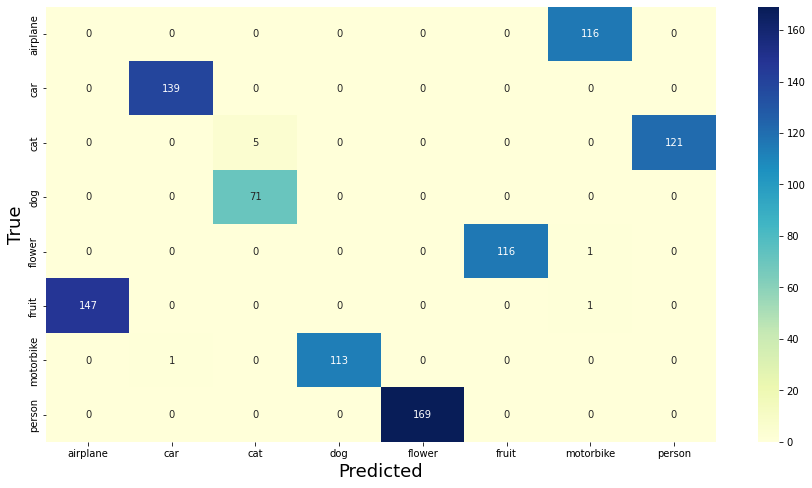

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
plt.figure(figsize=(15,8))
labels = ['airplane','car', 'cat', 'dog', 'flower', 'fruit', 'motorbike', 'person']
cm = confusion_matrix(df_kmean['Labels_test'], df_kmean['Labels'])
sns.heatmap(cm, annot=True, fmt="d", cmap="YlGnBu",xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted', fontsize=18)
plt.ylabel('True', fontsize=18)
plt.show()

Indice de rank

In [ ]:
from sklearn.metrics import rand_score
indice_rand= rand_score(df_kmean['Labels_test'], df_kmean['Labels'])
indice_rand

0.9965805805805806

Indice de van dongen

In [ ]:
def vanDongen(ct):
    n2=2*(sum(ct.apply(sum,axis=1)))
    sumi = sum(ct.apply(np.max,axis=1))
    sumj = sum(ct.apply(np.max,axis=0))
    maxsumi = np.max(ct.apply(sum,axis=1))
    maxsumj = np.max(ct.apply(sum,axis=0))
    vd = (n2 - sumi - sumj)/(n2 - maxsumi - maxsumj)
    return vd

In [ ]:
ct = pd.crosstab(df_kmean['Labels_test'], df_kmean['Labels'])
ct


Labels       airplane  car  cat  dog  flower  fruit  motorbike  person
Labels_test                                                           
airplane            0    0    0    0       0      0        116       0
car                 0  139    0    0       0      0          0       0
cat                 0    0    5    0       0      0          0     121
dog                 0    0   71    0       0      0          0       0
flower              0    0    0    0       0    116          1       0
fruit             147    0    0    0       0      0          1       0
motorbike           0    1    0  113       0      0          0       0
person              0    0    0    0     169      0          0       0

In [ ]:
vanDongen(ct)

0.009626955475330927

#### c) **Visualizar los clusters y las etiquetas** de género en baja dimensión con **alguna técnica de reducción (PCA, TSNE, MDS, etc)**.

([], <a list of 0 Text major ticklabel objects>)

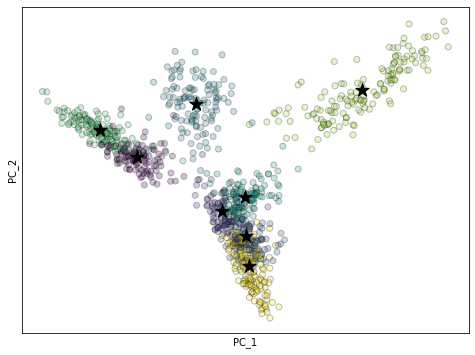

In [ ]:
pca = PCA(n_components=2, random_state=22)
pca.fit(x)
x_pca = pca.transform(x)

centroides_sklean_pca = pca.transform(kmeans.cluster_centers_)

plt.figure(1, figsize=(8, 6))
plt.clf()
plt.scatter(x_pca[:, 0], x_pca[:, 1], 
            c=kmeans.labels_, alpha=.25, edgecolor='k')

a=plt.scatter(centroides_sklean_pca[:, 0], centroides_sklean_pca[:, 1], 
            s=200, marker = '*', c='k', edgecolor=None)
plt.xlabel('PC_1')
plt.ylabel('PC_2')
plt.xticks(())
plt.yticks(())


In [ ]:
# Levanta archivos y extrae features
names, feat = preprocess(path, model)

1/1 [==============================] - 1s 535ms/step


In [ ]:
# reduce the amount of dimensions in the feature vector
pca = PCA(n_components=100, random_state=22)
pca.fit(feat)
x = pca.transform(feat)


In [ ]:
print(f"Components before PCA: {feat.shape[1]}")
print(f"Components after PCA: {pca.n_components}")


Components before PCA: 4096
Components after PCA: 100


#### (d) Discuta brevemente los resultados obtenidos.

conclusiones

### 2.1.2 KMeans combinación de otros parámetros 1

* init: k-means++
* n_initint =20
* max_iterint= 5000
* tolfloat=1e-5
* algorithm=”lloyd”

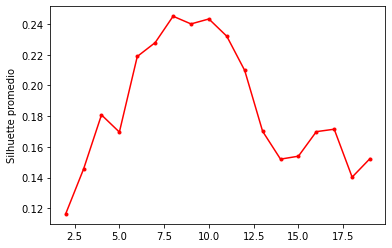

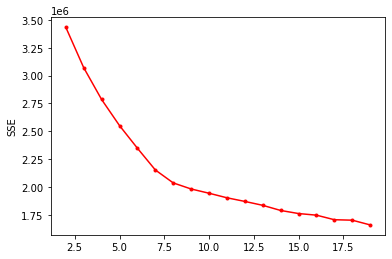

In [ ]:
from sklearn.metrics import silhouette_samples, silhouette_score
range_k = [i for i in range(2,20)]
silh = []
sse = []
for k in range_k:
    Kmeans = KMeans(n_clusters=k, random_state=22, n_init=20, max_iter=500, tol=0.00001).fit(x)

    silh.append(silhouette_score(x,Kmeans.labels_))
    sse.append(Kmeans.inertia_)

plt.plot(range_k,silh,'r.-')
plt.ylabel('Silhuette promedio')
plt.show()

plt.plot(range_k,sse,'r.-')
plt.ylabel('SSE')
plt.show()

In [ ]:
#kmeans = KMeans(n_clusters=len(unique_labels))
kmeans = KMeans(n_clusters=8, random_state=22, n_init=20, max_iter=500, tol=0.00001)
kmeans.fit(x)

KMeans(max_iter=500, n_init=20, random_state=22, tol=1e-05)

In [ ]:
# holds the cluster id and the images { id: [images] }
groups = {}
for file, cluster in zip(names,kmeans.labels_):
    if cluster not in groups.keys():
        groups[cluster] = []
        groups[cluster].append(file)
    else:
        groups[cluster].append(file)
    

Clipping cluster size from 113 to 10
Clipping cluster size from 76 to 10
Clipping cluster size from 121 to 10
Clipping cluster size from 118 to 10
Clipping cluster size from 116 to 10
Clipping cluster size from 140 to 10
Clipping cluster size from 147 to 10
Clipping cluster size from 169 to 10


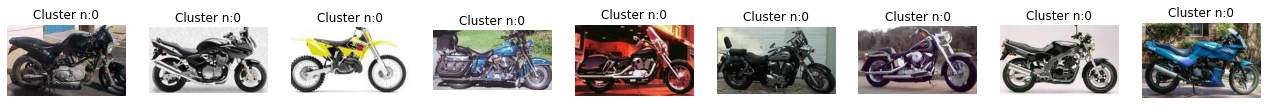

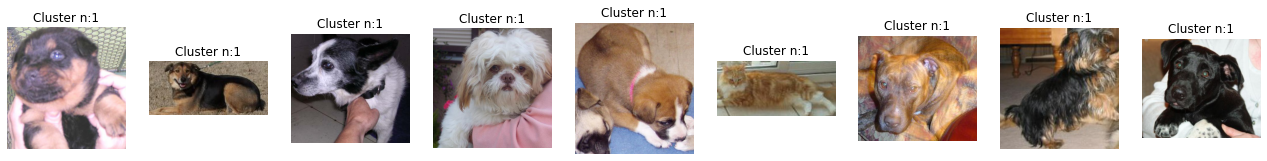

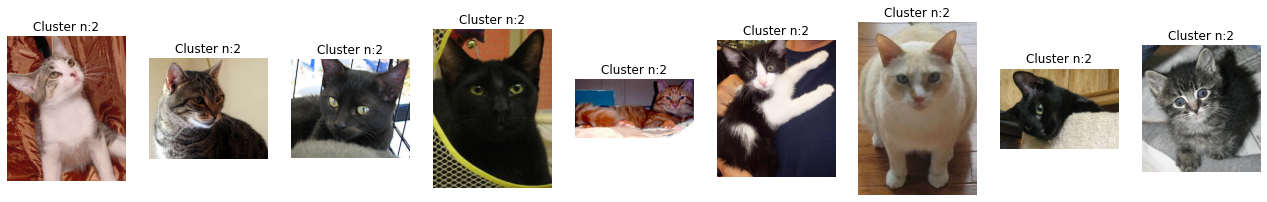

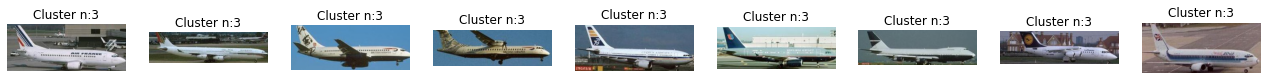

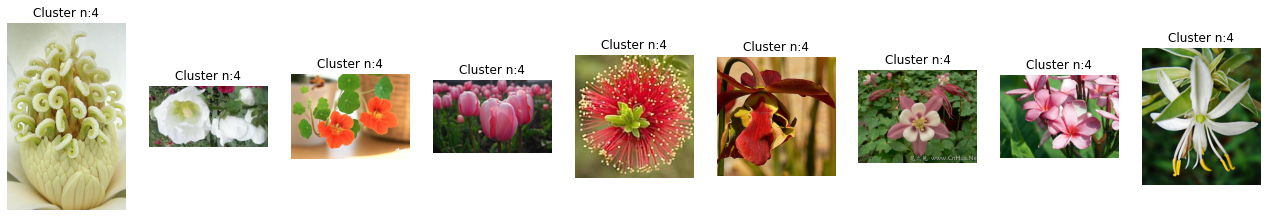

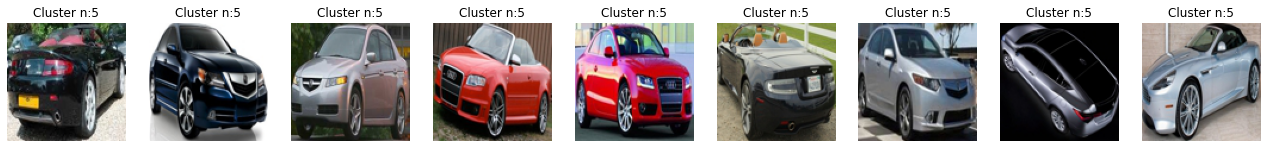

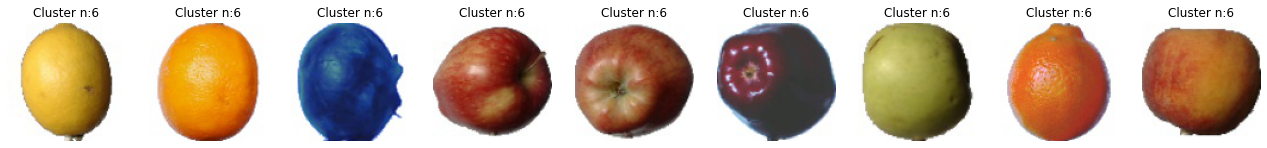

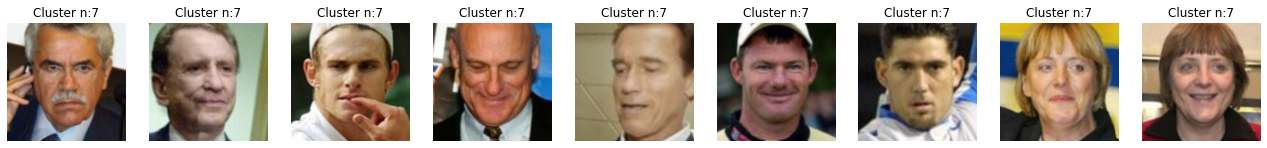

In [ ]:
for n in range(len(groups)):
  view_cluster(groups[n],n)

#### (b) **Evaluar si el agrupamiento para el k óptimo se condice que las etiquetas de las imágenes**  utilizando:

> la **matriz de confusión** y  

> los **índices de Rand y van Dongen** en los casos que correspondan.



In [ ]:
from tensorflow.python.eager.context import DEVICE_PLACEMENT_SILENT_FOR_INT32
df_0=pd.DataFrame(groups[0],columns=["path"])
df_0['Labels'] = pd.Series(['flower' for x in range(len(df_0.index))])
df_1=pd.DataFrame(groups[1],columns=["path"])
df_1['Labels'] = pd.Series(['person' for x in range(len(df_1.index))])
df_2=pd.DataFrame(groups[2],columns=["path"])
df_2['Labels'] = pd.Series(['dog' for x in range(len(df_2.index))])
df_3=pd.DataFrame(groups[3],columns=["path"])
df_3['Labels'] = pd.Series(['car' for x in range(len(df_3.index))])
df_4=pd.DataFrame(groups[4],columns=["path"])
df_4['Labels'] = pd.Series(['cat' for x in range(len(df_4.index))])
df_5=pd.DataFrame(groups[5],columns=["path"])
df_5['Labels'] = pd.Series(['airplane' for x in range(len(df_5.index))])
df_6=pd.DataFrame(groups[6],columns=["path"])
df_6['Labels'] = pd.Series(['motorbike' for x in range(len(df_6.index))])
df_7=pd.DataFrame(groups[7],columns=["path"])
df_7['Labels'] = pd.Series(['fruit' for x in range(len(df_7.index))])
df_kmean=pd.concat([df_0, df_1, df_2, df_3, df_4, df_5, df_6, df_7])
labelstest = df_kmean["path"].str.split('/',expand=True)
labelstest.columns = ['1', '2', '3','4', '5','6','Labels_test','8']
label_test = labelstest['Labels_test']
df_kmean = pd.concat([df_kmean,label_test], axis=1)
df_kmean

path  Labels Labels_test
0    /content/drive/MyDrive/Colab Notebooks/natural...  flower   motorbike
1    /content/drive/MyDrive/Colab Notebooks/natural...  flower   motorbike
2    /content/drive/MyDrive/Colab Notebooks/natural...  flower   motorbike
3    /content/drive/MyDrive/Colab Notebooks/natural...  flower   motorbike
4    /content/drive/MyDrive/Colab Notebooks/natural...  flower   motorbike
..                                                 ...     ...         ...
164  /content/drive/MyDrive/Colab Notebooks/natural...   fruit      person
165  /content/drive/MyDrive/Colab Notebooks/natural...   fruit      person
166  /content/drive/MyDrive/Colab Notebooks/natural...   fruit      person
167  /content/drive/MyDrive/Colab Notebooks/natural...   fruit      person
168  /content/drive/MyDrive/Colab Notebooks/natural...   fruit      person

[1000 rows x 3 columns]

In [ ]:
a= df_kmean[df_kmean['Labels']=='flower']
b=a[a['Labels_test']=='flower']
b

Empty DataFrame
Columns: [path, Labels, Labels_test]
Index: []

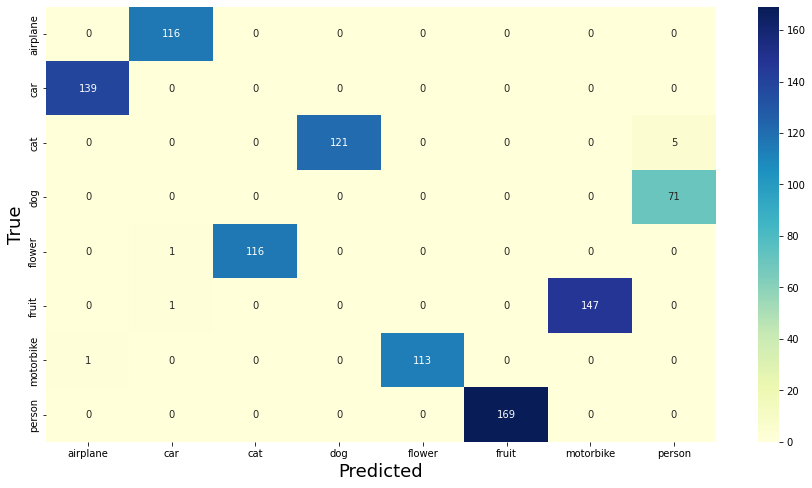

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
plt.figure(figsize=(15,8))
labels = ['airplane','car', 'cat', 'dog', 'flower', 'fruit', 'motorbike', 'person']
cm = confusion_matrix(df_kmean['Labels_test'], df_kmean['Labels'])
sns.heatmap(cm, annot=True, fmt="d", cmap="YlGnBu",xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted', fontsize=18)
plt.ylabel('True', fontsize=18)
plt.show()

Indice de rank

In [ ]:
from sklearn.metrics import rand_score
indice_rand= rand_score(df_kmean['Labels_test'], df_kmean['Labels'])
indice_rand

0.9965805805805806

Indice de van dongen

In [ ]:
def vanDongen(ct):
    n2=2*(sum(ct.apply(sum,axis=1)))
    sumi = sum(ct.apply(np.max,axis=1))
    sumj = sum(ct.apply(np.max,axis=0))
    maxsumi = np.max(ct.apply(sum,axis=1))
    maxsumj = np.max(ct.apply(sum,axis=0))
    vd = (n2 - sumi - sumj)/(n2 - maxsumi - maxsumj)
    return vd

In [ ]:
ct = pd.crosstab(df_kmean['Labels_test'], df_kmean['Labels'])
ct


Labels       airplane  car  cat  dog  flower  fruit  motorbike  person
Labels_test                                                           
airplane            0  116    0    0       0      0          0       0
car               139    0    0    0       0      0          0       0
cat                 0    0    0  121       0      0          0       5
dog                 0    0    0    0       0      0          0      71
flower              0    1  116    0       0      0          0       0
fruit               0    1    0    0       0      0        147       0
motorbike           1    0    0    0     113      0          0       0
person              0    0    0    0       0    169          0       0

In [ ]:
vanDongen(ct)

0.009626955475330927

#### c) **Visualizar los clusters y las etiquetas** de género en baja dimensión con **alguna técnica de reducción (PCA, TSNE, MDS, etc)**.

([], <a list of 0 Text major ticklabel objects>)

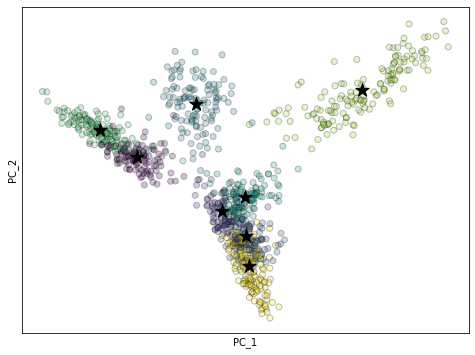

In [ ]:
pca = PCA(n_components=2, random_state=22)
pca.fit(x)
x_pca = pca.transform(x)

centroides_sklean_pca = pca.transform(kmeans.cluster_centers_)

plt.figure(1, figsize=(8, 6))
plt.clf()
plt.scatter(x_pca[:, 0], x_pca[:, 1], 
            c=kmeans.labels_, alpha=.25, edgecolor='k')

a=plt.scatter(centroides_sklean_pca[:, 0], centroides_sklean_pca[:, 1], 
            s=200, marker = '*', c='k', edgecolor=None)
plt.xlabel('PC_1')
plt.ylabel('PC_2')
plt.xticks(())
plt.yticks(())


In [ ]:
# Levanta archivos y extrae features
names, feat = preprocess(path, model)

1/1 [==============================] - 1s 542ms/step


In [ ]:
# reduce the amount of dimensions in the feature vector
pca = PCA(n_components=100, random_state=22)
pca.fit(feat)
x = pca.transform(feat)


In [ ]:
print(f"Components before PCA: {feat.shape[1]}")
print(f"Components after PCA: {pca.n_components}")


Components before PCA: 4096
Components after PCA: 100


#### (d) Discuta brevemente los resultados obtenidos.

conclusiones

### 2.1.3 KMeans combinación de otros parámetros 1

Tambien se aplica una mayor reducción

In [ ]:
# reduce the amount of dimensions in the feature vector
pca = PCA(n_components=20, random_state=22)
pca.fit(feat)
x = pca.transform(feat)

* init: k-means++
* n_init =20
* max_iter= 300
* tolfloat=1e-4
* algorithm=”lloyd”

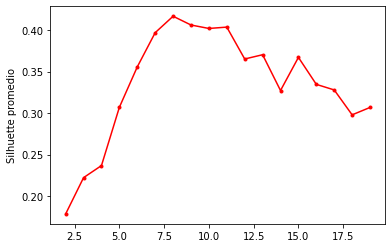

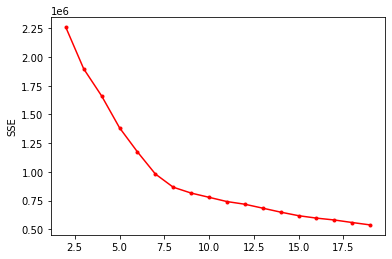

In [ ]:
from sklearn.metrics import silhouette_samples, silhouette_score
range_k = [i for i in range(2,20)]
silh = []
sse = []
for k in range_k:
    Kmeans = KMeans(n_clusters=k, random_state=22).fit(x)

    silh.append(silhouette_score(x,Kmeans.labels_))
    sse.append(Kmeans.inertia_)

plt.plot(range_k,silh,'r.-')
plt.ylabel('Silhuette promedio')
plt.show()

plt.plot(range_k,sse,'r.-')
plt.ylabel('SSE')
plt.show()

In [ ]:
#kmeans = KMeans(n_clusters=len(unique_labels))
kmeans = KMeans(n_clusters=8, random_state=22)
kmeans.fit(x)

KMeans(random_state=22)

In [ ]:
# holds the cluster id and the images { id: [images] }
groups = {}
for file, cluster in zip(names,kmeans.labels_):
    if cluster not in groups.keys():
        groups[cluster] = []
        groups[cluster].append(file)
    else:
        groups[cluster].append(file)
    

Clipping cluster size from 74 to 10
Clipping cluster size from 139 to 10
Clipping cluster size from 147 to 10
Clipping cluster size from 123 to 10
Clipping cluster size from 169 to 10
Clipping cluster size from 118 to 10
Clipping cluster size from 116 to 10
Clipping cluster size from 114 to 10


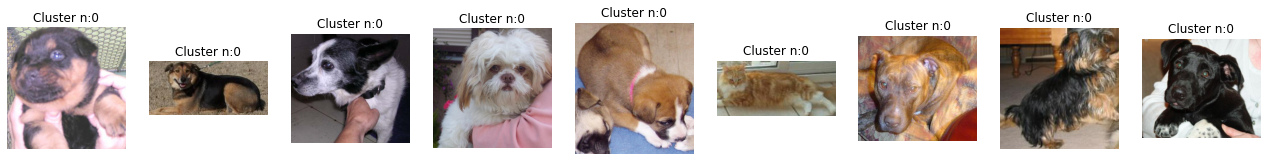

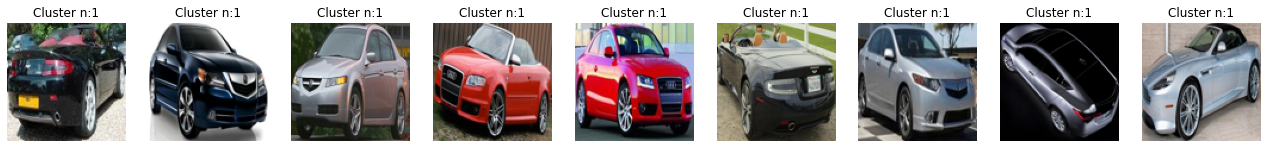

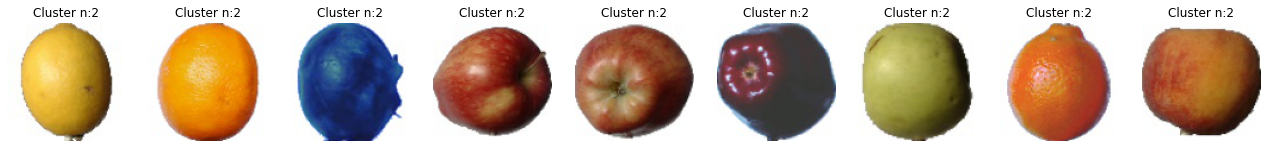

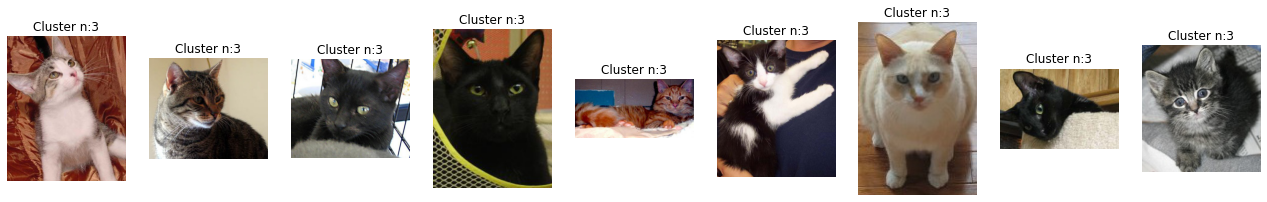

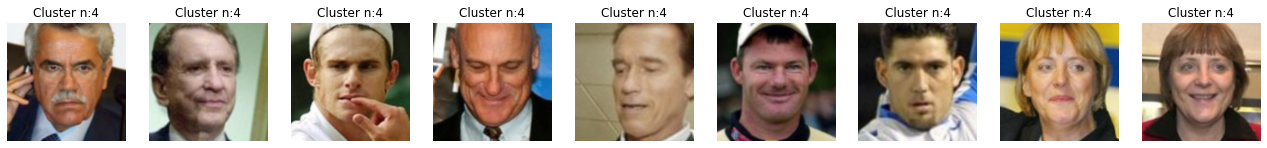

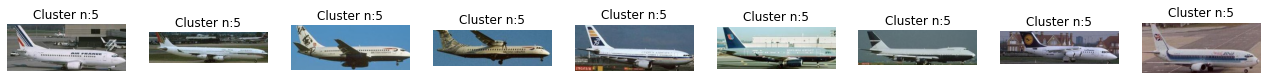

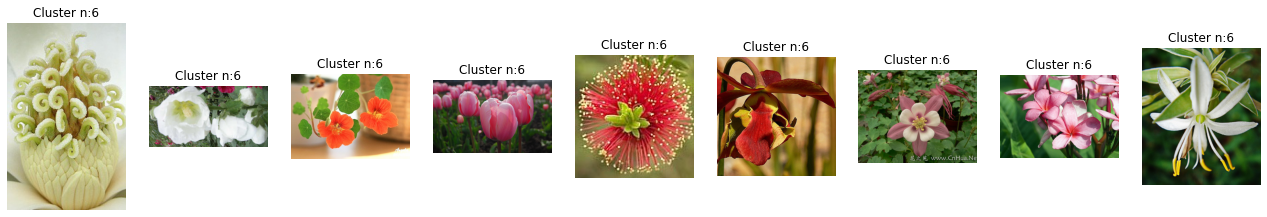

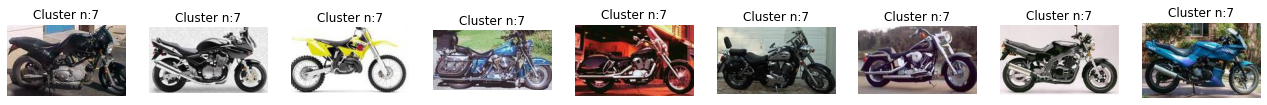

In [ ]:
for n in range(len(groups)):
  view_cluster(groups[n],n)

#### (b) **Evaluar si el agrupamiento para el k óptimo se condice que las etiquetas de las imágenes**  utilizando:

> la **matriz de confusión** y  

> los **índices de Rand y van Dongen** en los casos que correspondan.



In [ ]:

df_0=pd.DataFrame(groups[0],columns=["path"])
df_0['Labels'] = pd.Series(['cat' for x in range(len(df_0.index))])
df_1=pd.DataFrame(groups[1],columns=["path"])
df_1['Labels'] = pd.Series(['flower' for x in range(len(df_1.index))])
df_2=pd.DataFrame(groups[2],columns=["path"])
df_2['Labels'] = pd.Series(['car' for x in range(len(df_2.index))])
df_3=pd.DataFrame(groups[3],columns=["path"])
df_3['Labels'] = pd.Series(['fruit' for x in range(len(df_3.index))])
df_4=pd.DataFrame(groups[4],columns=["path"])
df_4['Labels'] = pd.Series(['dog' for x in range(len(df_4.index))])
df_5=pd.DataFrame(groups[5],columns=["path"])
df_5['Labels'] = pd.Series(['airplane' for x in range(len(df_5.index))])
df_6=pd.DataFrame(groups[6],columns=["path"])
df_6['Labels'] = pd.Series(['person' for x in range(len(df_6.index))])
df_7=pd.DataFrame(groups[7],columns=["path"])
df_7['Labels'] = pd.Series(['motorbike' for x in range(len(df_7.index))])
df_kmean=pd.concat([df_0, df_1, df_2, df_3, df_4, df_5, df_6, df_7])
labelstest = df_kmean["path"].str.split('/',expand=True)
labelstest.columns = ['1', '2', '3','4', '5','6','Labels_test','8']
label_test = labelstest['Labels_test']
df_kmean = pd.concat([df_kmean,label_test], axis=1)
df_kmean

path     Labels Labels_test
0    /content/drive/MyDrive/Colab Notebooks/natural...        cat         dog
1    /content/drive/MyDrive/Colab Notebooks/natural...        cat         dog
2    /content/drive/MyDrive/Colab Notebooks/natural...        cat         dog
3    /content/drive/MyDrive/Colab Notebooks/natural...        cat         dog
4    /content/drive/MyDrive/Colab Notebooks/natural...        cat         dog
..                                                 ...        ...         ...
109  /content/drive/MyDrive/Colab Notebooks/natural...  motorbike   motorbike
110  /content/drive/MyDrive/Colab Notebooks/natural...  motorbike   motorbike
111  /content/drive/MyDrive/Colab Notebooks/natural...  motorbike   motorbike
112  /content/drive/MyDrive/Colab Notebooks/natural...  motorbike   motorbike
113  /content/drive/MyDrive/Colab Notebooks/natural...  motorbike   motorbike

[1000 rows x 3 columns]

In [ ]:
a= df_kmean[df_kmean['Labels']=='flower']
b=a[a['Labels_test']=='flower']
b

Empty DataFrame
Columns: [path, Labels, Labels_test]
Index: []

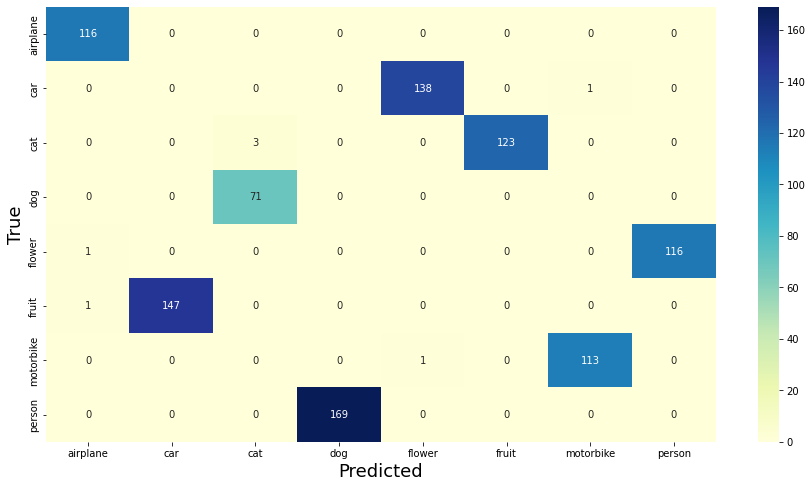

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
plt.figure(figsize=(15,8))
labels = ['airplane','car', 'cat', 'dog', 'flower', 'fruit', 'motorbike', 'person']
cm = confusion_matrix(df_kmean['Labels_test'], df_kmean['Labels'])
sns.heatmap(cm, annot=True, fmt="d", cmap="YlGnBu",xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted', fontsize=18)
plt.ylabel('True', fontsize=18)
plt.show()

Indice de rank

In [ ]:
from sklearn.metrics import rand_score
indice_rand= rand_score(df_kmean['Labels_test'], df_kmean['Labels'])
indice_rand

0.9968368368368369

Indice de van dongen

In [ ]:
def vanDongen(ct):
    n2=2*(sum(ct.apply(sum,axis=1)))
    sumi = sum(ct.apply(np.max,axis=1))
    sumj = sum(ct.apply(np.max,axis=0))
    maxsumi = np.max(ct.apply(sum,axis=1))
    maxsumj = np.max(ct.apply(sum,axis=0))
    vd = (n2 - sumi - sumj)/(n2 - maxsumi - maxsumj)
    return vd

In [ ]:
ct = pd.crosstab(df_kmean['Labels_test'], df_kmean['Labels'])
ct


Labels       airplane  car  cat  dog  flower  fruit  motorbike  person
Labels_test                                                           
airplane          116    0    0    0       0      0          0       0
car                 0    0    0    0     138      0          1       0
cat                 0    0    3    0       0    123          0       0
dog                 0    0   71    0       0      0          0       0
flower              1    0    0    0       0      0          0     116
fruit               1  147    0    0       0      0          0       0
motorbike           0    0    0    0       1      0        113       0
person              0    0    0  169       0      0          0       0

In [ ]:
vanDongen(ct)

0.00842358604091456

#### c) **Visualizar los clusters y las etiquetas** de género en baja dimensión con **alguna técnica de reducción (PCA, TSNE, MDS, etc)**.

([], <a list of 0 Text major ticklabel objects>)

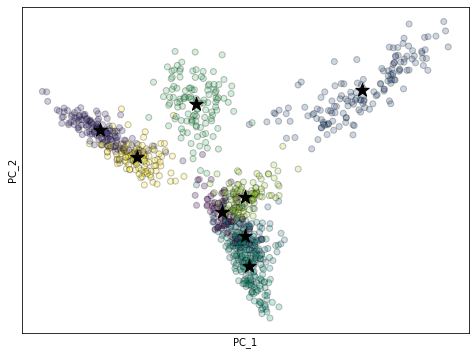

In [ ]:
pca = PCA(n_components=2, random_state=22)
pca.fit(x)
x_pca = pca.transform(x)

centroides_sklean_pca = pca.transform(kmeans.cluster_centers_)

plt.figure(1, figsize=(8, 6))
plt.clf()
plt.scatter(x_pca[:, 0], x_pca[:, 1], 
            c=kmeans.labels_, alpha=.25, edgecolor='k')

a=plt.scatter(centroides_sklean_pca[:, 0], centroides_sklean_pca[:, 1], 
            s=200, marker = '*', c='k', edgecolor=None)
plt.xlabel('PC_1')
plt.ylabel('PC_2')
plt.xticks(())
plt.yticks(())


#### (d) Discuta brevemente los resultados obtenidos.

Conclusiones:
En los tres variantes propuestas se obtiene muy buenos resultados. Indice de rand superior a 0,99 y indice de van dongen inferior a 0.02. En el caso que se aumento los parametros n_init,max_iter= 300 y disminuir el tol se obtuvieron peores resultados que los valores por default. En el tercer caso se dejaron los parametros por default y se realizó una mayor reducción (20). Dío perores resultados pero de igual modo se obtuvo un buen valor. 

## 2.2 Algoritmo **2** de clustering
En el paso a) considerar los hiper-parámetros y la métrica de validación interna que corresponda.

#### (a) **Aplicar Algoritmo 2 clustering** sobre el conjuntos de datos 
> con **distintas métricas, normalizaciones, combinaciones**, etc
 
> Determinar la **cantidad de clusters****


#### (b) **Evaluar si el agrupamiento para el k óptimo se condice que las etiquetas de las imágenes**  utilizando:

> la **matriz de confusión** y  

> los **índices de Rand y van Dongen** en los casos que correspondan.



#### c) **Visualizar los clusters y las etiquetas** de género en baja dimensión con **alguna técnica de reducción (PCA, TSNE, MDS, etc)**.

#### (d) Discuta brevemente los resultados obtenidos.

conclusiones

## 2.3 Algoritmo **3** de clustering
En el paso a) considerar los hiper-parámetros y la métrica de validación interna que corresponda.

#### (a) **Aplicar Algoritmo 3 clustering** sobre el conjuntos de datos 
> con **distintas métricas, normalizaciones, combinaciones**, etc
 
> Determinar la **cantidad de clusters****


#### (b) **Evaluar si el agrupamiento para el k óptimo se condice que las etiquetas de las imágenes**  utilizando:

> la **matriz de confusión** y  

> los **índices de Rand y van Dongen** en los casos que correspondan.



#### c) **Visualizar los clusters y las etiquetas** de género en baja dimensión con **alguna técnica de reducción (PCA, TSNE, MDS, etc)**.

#### (d) Discuta brevemente los resultados obtenidos.

conclusiones

## 2.4 **Comparar** y discutir brevemente los resultados obtenidos.

# 3. **Detección de objetos dentro de una imagen**

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import skimage.io
import skimage.color
import skimage.filters
import skimage.measure


#### (a) Seleccionar una sóla imagen.

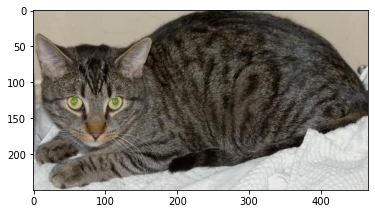

In [ ]:
    # load the image
    image = skimage.io.imread('/content/drive/MyDrive/Colab Notebooks/natural_images/cat/cat_0123.jpg')
    plt.imshow(image)

#### (b) Convertir la imagen a binaria.

In [ ]:

    # convert the image to grayscale
    gray_image = skimage.color.rgb2gray(image)
    # denoise the image with a Gaussian filter
    #blurred_image = skimage.filters.gaussian(gray_image, sigma=2)
    # mask the image according to threshold
    binary_mask = blurred_image < 0.56

    plt.imshow(binary_mask)
    

NameError: ignored

#### (c) Aplicar los algoritmos de **Connected-component labelling** y **clustering espectral** sobre los pixels.

Connected_component labelling

In [ ]:
# perform connected component analysis
labeled_image, count = skimage.measure.label(binary_mask, connectivity=2, return_num=True)
plt.imshow(labeled_image)

In [ ]:
count

clustering espectral 

#### (d) Describir el proceso y **comparar los resultados** obtenidos.